# HDF-N master catalogue
## Preparation of Hawaii-HDFN data

The catalogue comes from `dmu0_Hawaii-HDFN`.

It contains UBVRIz data.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The kron magnitude, there doesn't appear to be aperture magnitudes. This may mean the survey is unusable.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
33f5ec7 (Wed Dec 6 16:56:17 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table, vstack
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates, nb_merge_dist_plot
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "hawaii_ra"
DEC_COL = "hawaii_dec"

## I - Column selection

In [4]:
catalogue = Table.read("../../dmu0/dmu0_Hawaii-HDFN/data/R.fits")
catalogue[:10].show_in_notebook()

idx,ID,RA,DEC,x[0],x[1],Ufwhm,Ue[0],Ue[1],Bfwhm,Be[0],Be[1],Vfwhm,Ve[0],Ve[1],Rfwhm,Re[0],Re[1],Ifwhm,Ie[0],Ie[1],Zfwhm,Ze[0],Ze[1],HKfwhm,HKe[0],HKe[1],Uaperflux,dUaperflux,Ubkg,Uisoflux,dUisoflux,Uisobkg,Baperflux,dBaperflux,Bbkg,Bisoflux,dBisoflux,Bisobkg,Vaperflux,dVaperflux,Vbkg,Visoflux,dVisoflux,Visobkg,Raperflux,dRaperflux,Rbkg,Risoflux,dRisoflux,Risobkg,Iaperflux,dIaperflux,Ibkg,Iisoflux,dIisoflux,Iisobkg,Zaperflux,dZaperflux,Zbkg,Zisoflux,dZisoflux,Zisobkg,HKaperflux,dHKaperflux,HKbkg,HKisoflux,dHKisoflux,HKisobkg,U,dU,Uiso,dUiso,B,dB,Biso,dBiso,V,dV,Viso,dViso,R,dR,Riso,dRiso,I,dI,Iiso,dIiso,Z,dZ,Ziso,dZiso,HK,dHK,HKiso,dHKiso,bad,Usat,Bsat,Vsat,Rsat,Isat,Zsat,HKsat,N
0,386,189.55903,61.96553,2671.465,1792.146,0.0,0.5848,0.5266,3.328,0.5848,0.5266,3.328,0.5848,0.5266,2.066,0.5848,0.5266,1.822,0.5848,0.5266,1.828,0.5848,0.5266,0.0,0.5848,0.5266,186.48803,24.941872,0.044896,132.4685,22.220602,0.037391,172.83813,20.483855,0.035884,151.8612,15.25858,0.060688,196.12702,32.41374,-0.06002,211.45136,24.814562,0.026841,310.43013,27.745662,0.176284,257.04278,21.194017,0.143791,340.54061,62.782756,-0.030993,303.45514,39.264866,0.14627,758.16762,94.126535,0.339576,680.94821,66.176116,0.318273,-99.0,0.0,-4.61169e+18,-99.0,0.0,-4.61169e+18,25.723373,0.14521159,26.094718,0.18212436,25.805901,0.12867579,25.946383,0.10908167,25.709656,0.17943869,25.667974,0.12741512,25.17009,0.097040879,25.374986,0.089522499,25.069578,0.20016823,25.194764,0.14048652,24.200587,0.13479453,24.317215,0.1055142,-99.0596,0.0,-99.0,0.0,0,0,0,0,0,0,0,0,0
1,389,189.64881,61.964594,2165.028,1783.8416,0.0,0.7762,0.6422,2.9,0.7762,0.6422,2.266,0.7762,0.6422,1.352,0.7762,0.6422,1.152,0.7762,0.6422,1.214,0.7762,0.6422,0.0,0.7762,0.6422,343.06872,28.467733,-0.057943,307.5864,30.982559,-0.048257,444.64608,34.16004,-0.000789,428.55247,22.703589,0.09788,708.90213,43.219031,0.11646,739.1745,38.626473,0.240301,1223.7051,38.671083,0.826943,1129.2549,34.338951,0.726486,1393.4559,85.950157,1.100461,1497.5464,56.465918,0.211036,1585.405,117.50981,2.046424,1569.5686,95.716626,1.197774,-99.0,0.0,-4.61169e+18,-99.0,0.0,-4.61169e+18,25.061547,0.09009394,25.180082,0.1093643,24.779964,0.083411932,24.81999,0.057511555,24.314534,0.06619353,24.309133,0.056736413,23.680808,0.034310602,23.76802,0.033015985,23.539767,0.066969447,23.461549,0.040938349,23.399649,0.080474792,23.410549,0.066211381,-99.0596,0.0,-99.0,0.0,0,0,0,0,0,0,0,0,0
2,390,189.6508,61.963984,2153.7563,1776.5944,0.0,1.3848,1.2218,2.672,1.3848,1.2218,1.91,1.3848,1.2218,1.838,1.3848,1.2218,1.418,1.3848,1.2218,1.368,1.3848,1.2218,0.0,1.3848,1.2218,1493.6391,51.050594,-0.139095,2422.7332,81.690349,-0.115843,2097.9655,74.17831,-0.185239,3388.0593,59.511295,-0.1251,4140.4947,73.33219,-0.044415,6853.7917,95.788896,-0.025208,9662.898,76.55651,0.034059,14386.937,91.867563,0.09294,15003.387,208.07547,0.016075,20431.922,141.02593,0.19508,21293.46,281.24343,-0.155825,29336.797,242.91344,0.269873,-99.0,0.0,-4.61169e+18,-99.0,0.0,-4.61169e+18,23.464386,0.037108983,22.939236,0.036608836,23.095504,0.03838869,22.575122,0.019066964,22.398369,0.019229803,21.891173,0.015174028,21.437232,0.0086023593,21.005079,0.0069332309,20.959527,0.015057446,20.624227,0.0074940568,20.579384,0.014340321,20.231468,0.0089902129,-99.0596,0.0,-99.0,0.0,0,0,0,0,0,0,0,0,0
3,391,189.638,61.964894,2226.0216,1787.052,0.0,0.429,0.3608,2.358,0.429,0.3608,1.01,0.429,0.3608,1.432,0.429,0.3608,1.53,0.429,0.3608,2.358,0.429,0.3608,0.0,0.429,0.3608,90.919304,20.234254,-0.30735,47.241721,13.19696,-0.255972,97.502146,14.455302,-0.302281,75.296741,12.525248,-0.279774,150.1821,34.492765,-0.275632,145.29311,20.053294,-0.207495,209.24742,29.761036,0.336714,149.38028,16.530724,0.287927,226.10839,63.35523,-0.357887,192.69687,30.221682,-0.170836,322.70805,92.200991,-0.845605,263.15075,50.430449,-0.71671,-99.0,0.0,-4.61169e+18,-99.0,0.0,-4.61169e+18,26.50336,0.24163272,27.214186,0.3033003,26.427465,0.16096727,26.70806,0.18061191,25.999455,0.24936381,26.075387,0.14985276,25.59835,

In [5]:
imported_columns_old = OrderedDict({
        'ID': "hawaii_id",
        'RA': "hawaii_ra",
        'DEC': "hawaii_dec",
            'Uaperflux':  "f_ap_mosaic_u",
        'dUaperflux': "ferr_ap_mosaic_u",
        'Uisoflux': "f_mosaic_u",
        'dUisoflux': "ferr_mosaic_u",
           'Baperflux':  "f_ap_suprime_b",
        'dBaperflux': "ferr_ap_suprime_b",
        'Bisoflux': "f_suprime_b",
        'dBisoflux': "ferr_suprime_b",       
            'Vaperflux':  "f_ap_suprime_v",
        'dVaperflux': "ferr_ap_suprime_v",
        'Visoflux': "f_suprime_v",
        'dVisoflux': "ferr_suprime_v",
            'Raperflux':  "f_ap_suprime_r",
        'dRaperflux': "ferr_ap_suprime_r",
        'Risoflux': "f_suprime_r",
        'dRisoflux': "ferr_suprime_r",
            'Iaperflux':  "f_ap_suprime_i",
        'dIaperflux': "ferr_ap_suprime_i",
        'Iisoflux': "f_suprime_i",
        'dIisoflux': "ferr_suprime_i",
            'Zaperflux':  "f_ap_suprime_z",
        'dZaperflux': "ferr_ap_suprime_z",
        'Zisoflux': "f_suprime_z",
        'dZisoflux': "ferr_suprime_z",
            'HKaperflux':  "f_ap_quirc_hk",
        'dHKaperflux': "ferr_ap_quirc_hk",
        'HKisoflux': "f_quirc_hk",
        'dHKisoflux': "ferr_quirc_hk"

    })
imported_columns = OrderedDict({
        'ID': "hawaii_id",
        'RA': "hawaii_ra",
        'DEC': "hawaii_dec",
            'U':  "m_ap_mosaic_u",
        'dU': "merr_ap_mosaic_u",
        'Uiso': "m_mosaic_u",
        'dUiso': "merr_mosaic_u",
           'B':  "m_ap_suprime_b",
        'dB': "merr_ap_suprime_b",
        'Biso': "m_suprime_b",
        'dBiso': "merr_suprime_b",       
            'V':  "m_ap_suprime_v",
        'dV': "merr_ap_suprime_v",
        'Viso': "m_suprime_v",
        'dViso': "merr_suprime_v",
            'R':  "m_ap_suprime_r",
        'dR': "merr_ap_suprime_r",
        'Riso': "m_suprime_r",
        'dRiso': "merr_suprime_r",
            'I':  "m_ap_suprime_i",
        'dI': "merr_ap_suprime_i",
        'Iiso': "m_suprime_i",
        'dIiso': "merr_suprime_i",
            'Z':  "m_ap_suprime_z",
        'dZ': "merr_ap_suprime_z",
        'Ziso': "m_suprime_z",
        'dZiso': "merr_suprime_z",
            'HK':  "m_ap_quirc_hk",
        'dHK': "merr_ap_quirc_hk",
        'HKiso': "m_quirc_hk",
        'dHKiso': "merr_quirc_hk"

    })


catalogue = Table.read("../../dmu0/dmu0_Hawaii-HDFN/data/R.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012 #Year of publication

# Clean table metadata
catalogue.meta = None

In [6]:
catalogue_z = Table.read("../../dmu0/dmu0_Hawaii-HDFN/data/Z.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue_z[column].name = imported_columns[column]
    
catalogue_z['hawaii_id'] = catalogue_z['hawaii_id'] + 1000000


# Clean table metadata
catalogue_z.meta = None

In [7]:
catalogue_z[:10].show_in_notebook()

idx,hawaii_id,hawaii_ra,hawaii_dec,m_ap_mosaic_u,merr_ap_mosaic_u,m_mosaic_u,merr_mosaic_u,m_ap_suprime_b,merr_ap_suprime_b,m_suprime_b,merr_suprime_b,m_ap_suprime_v,merr_ap_suprime_v,m_suprime_v,merr_suprime_v,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_quirc_hk,merr_ap_quirc_hk,m_quirc_hk,merr_quirc_hk
0,1000200,189.00408,61.965609,27.001709,0.38528782,28.694728,0.82813119,26.837913,0.22746261,32.128865,23.501489,26.574437,0.38819905,27.425881,0.3705649,26.263358,0.27636734,27.513502,0.36892677,25.577387,0.33750432,26.384019,0.26115526,24.926273,0.24636432,25.627805,0.19121145,-99.0596,0.0,-99.0,0.0
1,1000398,188.83522,61.964762,26.140756,0.2035186,27.202913,0.3308604,25.809623,0.13760616,30.777327,10.506518,25.557598,0.15326846,26.197062,0.15292111,25.305778,0.12479015,26.381964,0.18644296,24.793982,0.15107171,25.390438,0.12071144,24.677853,0.17771922,25.217512,0.15486053,-99.0596,0.0,-99.0,0.0
2,1000683,189.55482,61.968059,25.793577,0.21057387,25.863714,0.2404283,25.549995,0.15287651,29.690869,7.186459,25.237118,0.13183282,24.998823,0.097637017,24.547955,0.067486469,24.569677,0.059156437,23.989988,0.095556132,23.880514,0.054872285,23.043226,0.069403152,22.984884,0.041449755,-99.0596,0.0,-99.0,0.0
3,1000684,189.65861,61.965408,25.243179,0.15505399,25.619759,0.18945418,24.9983,0.13705436,29.630392,7.2040115,24.953188,0.10684509,25.417499,0.099688236,24.541673,0.069864099,25.141868,0.073558968,24.218914,0.1067921,24.746546,0.078865981,23.801394,0.11186048,24.28883,0.088974033,-99.0596,0.0,-99.0,0.0
4,1000685,189.62183,62.076018,25.783978,0.19560823,26.776138,0.31511768,25.727592,0.16977649,30.578801,10.216514,25.462749,0.14959053,26.210649,0.1363267,25.276579,0.10019427,26.287501,0.11932207,25.15394,0.19956444,25.88833,0.14748907,24.860772,0.21450099,25.337239,0.14398722,-99.0596,0.0,-99.0,0.0
5,1000686,189.47361,62.075756,-27.839311,0.71420802,-28.570584,1.1922983,-28.714795,0.6762764,33.292467,87.071329,28.322043,1.6612291,27.952043,0.88240139,26.090807,0.18789899,26.511272,0.19391541,24.892444,0.17099695,25.230126,0.12622618,23.922299,0.1057615,24.116254,0.071454034,-99.0596,0.0,-99.0,0.0
6,1000687,189.66319,62.07204,25.38509,0.14859425,26.177527,0.23035857,25.498147,0.14719695,30.060253,7.2214863,25.149775,0.11410288,25.664488,0.095392155,24.712997,0.068065492,25.37001,0.064862269,24.526252,0.12353518,24.937349,0.070317746,24.09238,0.12203013,24.606171,0.087461352,-99.0596,0.0,-99.0,0.0
7,1000688,189.68571,62.07142,25.965912,0.21836919,27.10747,0.35848145,26.19472,0.2240355,30.812739,12.234777,26.192543,0.33789419,26.641556,0.20417163,26.176035,0.23785533,27.034543,0.21109795,26.399726,0.56831541,26.644547,0.24837228,25.044278,0.25451312,25.586877,0.15772759,-99.0596,0.0,-99.0,0.0
8,1000689,189.6282,62.066126,25.296538,0.15132431,26.299351,0.24512973,25.326706,0.1386452,30.113485,7.0796685,25.082057,0.10820616,25.781433,0.086221061,24.780212,0.072433805,25.953647,0.088951811,24.889043,0.15595774,25.867049,0.13265088,24.561796,0.17628444,25.328652,0.13357331,-99.0596,0.0,-99.0,0.0
9,1000690,189.65421,62.064643,25.494857,0.18194871,26.181892,0.24957131,25.405587,0.1402093,30.041409,7.542751,25.242488,0.12231369,25.675742,0.096630871,24.770654,0.070939161,25.510577,0.072889668,24.884826,0.16157141,25.488736,0.11682682,24.20326,0.12581477,24.760399,0.10005013,-99.0596,0.0,-99.0,0.0


In [8]:
catalogue[:10].show_in_notebook()

idx,hawaii_id,hawaii_ra,hawaii_dec,m_ap_mosaic_u,merr_ap_mosaic_u,m_mosaic_u,merr_mosaic_u,m_ap_suprime_b,merr_ap_suprime_b,m_suprime_b,merr_suprime_b,m_ap_suprime_v,merr_ap_suprime_v,m_suprime_v,merr_suprime_v,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_quirc_hk,merr_ap_quirc_hk,m_quirc_hk,merr_quirc_hk
0,386,189.55903,61.96553,25.723373,0.14521159,26.094718,0.18212436,25.805901,0.12867579,25.946383,0.10908167,25.709656,0.17943869,25.667974,0.12741512,25.17009,0.097040879,25.374986,0.089522499,25.069578,0.20016823,25.194764,0.14048652,24.200587,0.13479453,24.317215,0.1055142,-99.0596,0.0,-99.0,0.0
1,389,189.64881,61.964594,25.061547,0.09009394,25.180082,0.1093643,24.779964,0.083411932,24.81999,0.057511555,24.314534,0.06619353,24.309133,0.056736413,23.680808,0.034310602,23.76802,0.033015985,23.539767,0.066969447,23.461549,0.040938349,23.399649,0.080474792,23.410549,0.066211381,-99.0596,0.0,-99.0,0.0
2,390,189.6508,61.963984,23.464386,0.037108983,22.939236,0.036608836,23.095504,0.03838869,22.575122,0.019066964,22.398369,0.019229803,21.891173,0.015174028,21.437232,0.0086023593,21.005079,0.0069332309,20.959527,0.015057446,20.624227,0.0074940568,20.579384,0.014340321,20.231468,0.0089902129,-99.0596,0.0,-99.0,0.0
3,391,189.638,61.964894,26.50336,0.24163272,27.214186,0.3033003,26.427465,0.16096727,26.70806,0.18061191,25.999455,0.24936381,26.075387,0.14985276,25.59835,0.15442289,25.964267,0.12014978,25.514208,0.30422166,25.687813,0.17028152,25.127975,0.31020595,25.349488,0.20807133,-99.0596,0.0,-99.0,0.0
4,392,189.62859,61.964689,24.771493,0.076833894,25.052384,0.096562704,24.721853,0.079650762,24.873063,0.052074946,24.634868,0.082687321,24.679395,0.067883863,24.406471,0.05967945,24.572007,0.058246903,24.068952,0.096463265,24.185701,0.069235103,23.435325,0.082375992,23.595525,0.070384189,-99.0596,0.0,-99.0,0.0
5,393,189.68372,61.964465,25.094508,0.092319595,25.27516,0.11411862,24.790615,0.10128182,24.966089,0.076384354,24.386658,0.072231816,24.338447,0.057821412,23.719707,0.038360965,23.832724,0.036065599,23.201734,0.051587544,23.258345,0.031956488,22.966008,0.059527941,23.040993,0.04626716,-99.0596,0.0,-99.0,0.0
6,394,189.51139,61.965064,26.362513,0.22292727,27.455241,0.33621261,26.66095,0.20934897,26.965179,0.14818642,26.433495,0.39112474,26.610208,0.21105095,25.842772,0.16774134,26.523055,0.14513312,25.166884,0.2758452,25.48695,0.14345075,24.691507,0.21782669,25.249285,0.15404107,-99.0596,0.0,-99.0,0.0
7,395,189.55313,61.96473,25.569389,0.13045396,25.89583,0.15701327,25.392924,0.09119921,25.517522,0.067142119,25.26301,0.12530507,25.269382,0.0904852,24.840218,0.069804425,25.127067,0.068408088,25.014741,0.18773043,25.205088,0.1415407,24.568546,0.17587877,24.812179,0.16232668,-99.0596,0.0,-99.0,0.0
8,396,189.66667,61.964542,25.652312,0.13461441,26.023158,0.16550321,25.106556,0.11679617,25.424401,0.089626379,24.950604,0.11051377,25.002837,0.08047665,24.702825,0.080025438,24.981212,0.075006669,24.642145,0.14551468,24.901846,0.10796262,24.671045,0.22232358,25.055964,0.21920951,-99.0596,0.0,-99.0,0.0
9,397,189.50243,61.964403,24.11111,0.050901971,24.101583,0.061650936,23.853552,0.043662901,23.840911,0.026950046,23.391297,0.03807192,23.312244,0.030761295,22.646887,0.014220093,22.614868,0.013795126,22.219403,0.033839417,22.222227,0.021533315,21.857106,0.028142249,21.839776,0.02204149,-99.0596,0.0,-99.0,0.0


## III - Merging

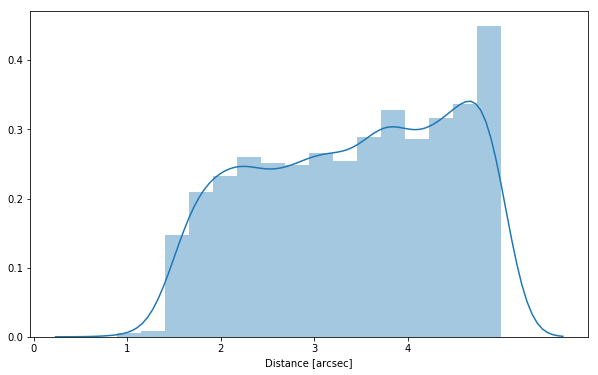

In [9]:
catalogue['hawaii_ra'].unit = u.deg
catalogue['hawaii_dec'].unit = u.deg
catalogue_z['hawaii_ra'].unit = u.deg
catalogue_z['hawaii_dec'].unit = u.deg
nb_merge_dist_plot(
    SkyCoord(catalogue['hawaii_ra'], catalogue['hawaii_dec']),
    SkyCoord(catalogue_z['hawaii_ra'], catalogue_z['hawaii_dec'])
)

The catalogues apper to contain no cross matches. We therefore simply stack the catalogues. We need to understand why this is the case. Have cross matches already been removed from the Z selected catalogue?

In [10]:
catalogue = vstack([catalogue, catalogue_z])

In [11]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        mask = catalogue[col] < 0.
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan
        
        
        flux, error = mag_to_flux(np.array(catalogue[col]) , np.array(catalogue[errcol] ))
        
        
        # magnitudes are added
        catalogue.add_column(Column(flux*1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error*1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [12]:
catalogue[:10].show_in_notebook()

idx,hawaii_id,hawaii_ra,hawaii_dec,m_ap_mosaic_u,merr_ap_mosaic_u,m_mosaic_u,merr_mosaic_u,m_ap_suprime_b,merr_ap_suprime_b,m_suprime_b,merr_suprime_b,m_ap_suprime_v,merr_ap_suprime_v,m_suprime_v,merr_suprime_v,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_quirc_hk,merr_ap_quirc_hk,m_quirc_hk,merr_quirc_hk,f_ap_mosaic_u,ferr_ap_mosaic_u,f_mosaic_u,ferr_mosaic_u,flag_mosaic_u,f_ap_suprime_b,ferr_ap_suprime_b,f_suprime_b,ferr_suprime_b,flag_suprime_b,f_ap_suprime_v,ferr_ap_suprime_v,f_suprime_v,ferr_suprime_v,flag_suprime_v,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_quirc_hk,ferr_ap_quirc_hk,f_quirc_hk,ferr_quirc_hk,flag_quirc_hk
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,386,189.55903,61.96553,25.723373,0.14521159,26.094718,0.18212436,25.805901,0.12867579,25.946383,0.10908167,25.709656,0.17943869,25.667974,0.12741512,25.17009,0.097040879,25.374986,0.089522499,25.069578,0.20016823,25.194764,0.14048652,24.200587,0.13479453,24.317215,0.1055142,nan,nan,nan,nan,0.186487960768,0.0249417981829,0.132468555321,0.0222206377132,False,0.172838146368,0.0204838752992,0.151861190443,0.0152571795885,False,0.188858962695,0.0312125585498,0.196250331945,0.0230306951958,False,0.310430225234,0.0277456179437,0.257042892689,0.0211940266916,False,0.340540524034,0.062782647977,0.303455071469,0.0392649216083,False,0.7581675632,0.0941267684498,0.680948080498,0.066176011853,False,nan,nan,nan,nan,False
1,389,189.64881,61.964594,25.061547,0.09009394,25.180082,0.1093643,24.779964,0.083411932,24.81999,0.057511555,24.314534,0.06619353,24.309133,0.056736413,23.680808,0.034310602,23.76802,0.033015985,23.539767,0.066969447,23.461549,0.040938349,23.399649,0.080474792,23.410549,0.066211381,nan,nan,nan,nan,0.343068781486,0.028467705212,0.307586450194,0.0309826426231,False,0.444646010453,0.0341600313459,0.428552467493,0.0227004669243,False,0.682631618037,0.0416176565628,0.686035832441,0.0358496033858,False,1.22370518443,0.0386705917738,1.12925494237,0.0343393395884,False,1.39345580777,0.0859499429572,1.49754678808,0.0564659194244,False,1.58540564423,0.117510302131,1.56956895474,0.0957169224093,False,nan,nan,nan,nan,False
2,390,189.6508,61.963984,23.464386,0.037108983,22.939236,0.036608836,23.095504,0.03838869,22.575122,0.019066964,22.398369,0.019229803,21.891173,0.015174028,21.437232,0.0086023593,21.005079,0.0069332309,20.959527,0.015057446,20.624227,0.0074940568,20.579384,0.014340321,20.231468,0.0089902129,nan,nan,nan,nan,1.49363884581,0.0510505390667,2.42273325178,0.081689681064,False,2.09796577941,0.0741783847527,3.38806083664,0.05949883012,False,3.98705659153,0.0706159677359,6.3610791577,0.0889011463615,False,9.66289365641,0.0765597414417,14.3869389265,0.0918712750708,False,15.0033831418,0.208073223022,20.431920966,0.141026867835,False,21.2934680308,0.281242502025,29.3368040456,0.242917306267,False,nan,nan,nan,nan,False
3,391,189.638,61.964894,26.50336,0.24163272,27.214186,0.3033003,26.427465,0.16096727,26.70806,0.18061191,25.999455,0.24936381,26.075387,0.14985276,25.59835,0.15442289,25.964267,0.12014978,25.514208,0.30422166,25.687813,0.17028152,25.127975,0.31020595,25.349488,0.20807133,nan,nan,nan,nan,0.0909192825457,0.0202342644979,0.0472417089875,0.0131969666717,False,0.0975021068176,0.0144553049672,0.0752967098898,0.0125255863536,False,0.144616551096,0.0332144530248,0.134848214371,0.0186116821158,False,0.20924736609,0.0297609887696,0.149380256215,0.0165307234317,False,0.226108453716,0.0633552504081,0.192696931935,0.0302216379315,False,0.322708199297,0.0922010365842,0.263150863837,0.0504304360389,False,nan,nan,nan,nan,False
4,392,189.62859,61.964689,24.771493,0.076833894,25.052384,0.096562704,24.721853,0.0796

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [13]:

SORT_COLS = ['merr_mosaic_u', 
             'merr_suprime_b', 
             'merr_suprime_v', 
             'merr_suprime_r',
             'merr_suprime_i',
             'merr_suprime_z',
             'merr_quirc_hk']
FLAG_NAME = 'hawaii_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 48858 sources.
The cleaned catalogue has 48858 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [14]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_HDF-N.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

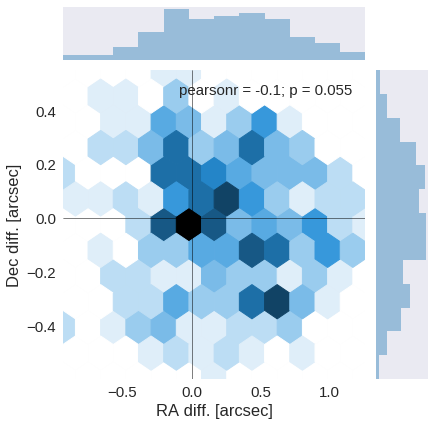

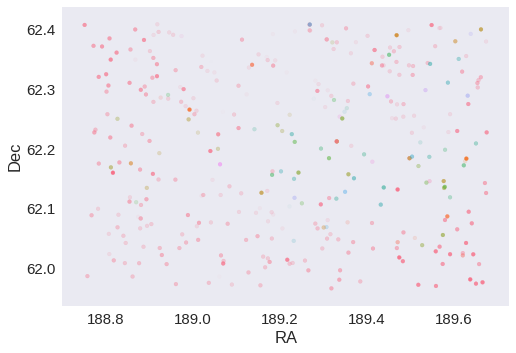

In [15]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [16]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.22843071726015296 arcsec
Dec correction: 0.014955391984017297 arcsec


In [17]:
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

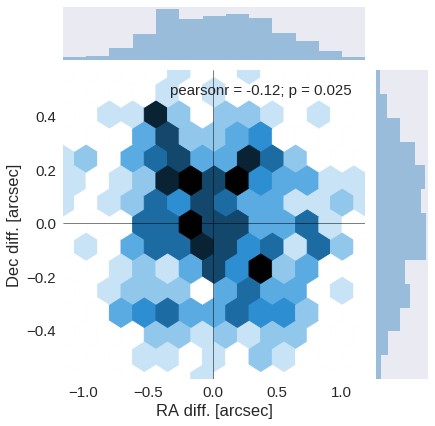

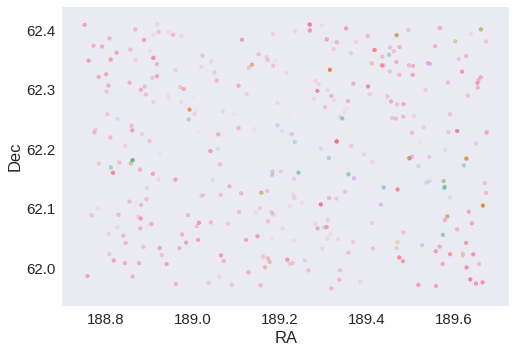

In [18]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [19]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [20]:
GAIA_FLAG_NAME = "hawaii_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

431 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [21]:
len(catalogue)

48858

In [22]:
catalogue[:10].show_in_notebook()

idx,hawaii_id,hawaii_ra,hawaii_dec,m_ap_mosaic_u,merr_ap_mosaic_u,m_mosaic_u,merr_mosaic_u,m_ap_suprime_b,merr_ap_suprime_b,m_suprime_b,merr_suprime_b,m_ap_suprime_v,merr_ap_suprime_v,m_suprime_v,merr_suprime_v,m_ap_suprime_r,merr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_i,merr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_z,merr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_quirc_hk,merr_ap_quirc_hk,m_quirc_hk,merr_quirc_hk,f_ap_mosaic_u,ferr_ap_mosaic_u,f_mosaic_u,ferr_mosaic_u,flag_mosaic_u,f_ap_suprime_b,ferr_ap_suprime_b,f_suprime_b,ferr_suprime_b,flag_suprime_b,f_ap_suprime_v,ferr_ap_suprime_v,f_suprime_v,ferr_suprime_v,flag_suprime_v,f_ap_suprime_r,ferr_ap_suprime_r,f_suprime_r,ferr_suprime_r,flag_suprime_r,f_ap_suprime_i,ferr_ap_suprime_i,f_suprime_i,ferr_suprime_i,flag_suprime_i,f_ap_suprime_z,ferr_ap_suprime_z,f_suprime_z,ferr_suprime_z,flag_suprime_z,f_ap_quirc_hk,ferr_ap_quirc_hk,f_quirc_hk,ferr_quirc_hk,flag_quirc_hk,hawaii_flag_cleaned,hawaii_flag_gaia
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,64757,188.910226547,62.3524671543,17.48232,0.0032547218,17.52763,0.0037206719,19.262871,0.010587683,nan,nan,17.321681,0.0090037634,17.16203,0.003637295,nan,nan,nan,nan,17.529042,0.0051077822,17.426093,0.0012591306,16.75208,0.015353546,nan,nan,17.18572,0.011530201,17.029669,0.012365919,369.038775008,1.10627106363,353.954957953,1.21295602021,False,71.5898743216,0.698116993801,nan,nan,False,427.885530002,3.54835737957,495.664710683,1.66051271565,False,nan,nan,nan,nan,False,353.494938701,1.66299617511,388.653694126,0.450722520749,False,723.049449835,10.2247423819,nan,nan,False,484.966790441,5.15020549891,559.928276481,6.37726519796,False,False,3
1,9521,189.620606547,62.0247091543,17.276633,0.0032096196,17.498646,0.0039690233,18.729508,0.0099520701,nan,nan,17.168774,0.0065314527,17.080994,0.0026401332,nan,nan,nan,nan,17.515398,0.0039837054,17.452045,0.0009023611,16.632781,0.0047726293,16.658149,0.0013916258,nan,nan,nan,nan,446.012263309,1.31848758095,363.53112463,1.32892639815,False,117.00294683,1.07247186163,nan,nan,False,492.595454497,2.96330167234,534.075185494,1.29868528132,False,nan,nan,nan,nan,False,357.965193194,1.31342020915,379.473978001,0.315382829374,False,807.026136328,3.54748839288,788.388716528,1.0105051978,False,nan,nan,nan,nan,False,False,3
2,32166,189.106776547,62.0937961543,17.652784,0.0037324369,17.619795,0.0041253927,17.956455,0.0060851658,nan,nan,17.468904,0.0075733022,17.120838,0.002651113,nan,nan,nan,nan,17.401498,0.0044828684,17.116824,0.0011168023,16.419461,0.0055624592,nan,nan,nan,nan,nan,nan,315.417946517,1.08431272471,325.148683556,1.23544374746,False,238.461350936,1.3364911762,nan,nan,False,373.627126635,2.60614975141,514.831130874,1.2570967956,False,nan,nan,nan,nan,False,397.558277256,1.64146818579,516.738000037,0.531523388839,False,982.235440359,5.03220260856,nan,nan,False,nan,nan,nan,nan,False,False,3
3,42605,189.406946547,62.2916271543,17.861218,0.004200027,17.824717,0.0046427915,19.155014,0.012868566,nan,nan,17.327195,0.0082108105,16.964173,0.002950561,nan,nan,nan,nan,17.049913,0.0049733921,16.776206,0.001131984,16.28526,0.0063242479,nan,nan,16.51948,0.018702164,16.358775,0.013662639,260.323155552,1.00702571882,269.2236451,1.151245805,False,79.0668432679,0.937130848677,nan,nan,False,425.717987069,3.21946500719,594.745000512,1.61625945212,False,nan,nan,nan,nan,False,549.584910311,2.51746348629,707.159858106,0.737281893438,False,1111.46553404,6.47411732127,nan,nan,False,895.793692197,15.4303416136,1038.6996852,13.0707429357,False,False,3
4,56545,189.628286547,62.3556161543,17.814164,0.0041586067,17.814242,0.0046634874,18.716585,0.0094207471,nan,nan,17.207484,0.0075612738,17.025781,0.0030234266,nan,nan,nan,nan,17.479952,0.0066494282,17.304919,0.0015447359,nan,nan,nan,nan,nan,nan,nan,nan,271.853169031,1.04125698783,271.833639623,1.16758817448,False,118.403897966,1.0273703442,nan,nan,False,475.342230793,3.31037386428,561.936963016,1.5648139521,Fals

In [23]:
catalogue.write("{}/Hawaii.fits".format(OUT_DIR), overwrite=True)